In [152]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from tf_keras_vis.activation_maximization import ActivationMaximization


import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [153]:
# Globals
NUM_CHANNELS = 3
RESOLUTION_LIST = [336] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-base-PrPo_Im-w-336-px-h-336-px/model'

In [154]:
## these can also be globally set.
trial_seed = 1
class_labels = getClassLabels("PrPo_Im")
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)
training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[336]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[336]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[336]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)

{336: {'PrPo_Im': array([[array([[[0.40392157, 0.50980392, 0.32156863],
                [0.4745098 , 0.57647059, 0.33333333],
                [0.56078431, 0.6627451 , 0.35686275],
                ...,
                [0.20784314, 0.27843137, 0.18431373],
                [0.13333333, 0.19607843, 0.14509804],
                [0.1254902 , 0.18823529, 0.1372549 ]],

               [[0.39215686, 0.50980392, 0.29411765],
                [0.52156863, 0.64313725, 0.32941176],
                [0.41568627, 0.53333333, 0.2745098 ],
                ...,
                [0.17647059, 0.23921569, 0.17254902],
                [0.12941176, 0.19607843, 0.14901961],
                [0.11372549, 0.17647059, 0.1372549 ]],

               [[0.25098039, 0.36470588, 0.29411765],
                [0.31372549, 0.41960784, 0.30196078],
                [0.35686275, 0.47058824, 0.31764706],
                ...,
                [0.11372549, 0.16862745, 0.12941176],
                [0.11372549, 0.17647059, 0.12941176

In [5]:
GLOBAL_MODEL = models.load_model(FULL_MODEL_PATH)

Obtaining the class activation maps (CAM) and gradients from the three visualization techniques.

In [155]:
def grad_cam(index): 
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_img = index # class activation map corresponds to the specified image index 
    probPrediction = [] # store probability of prediction by the CNN
    predictedClass = [] # store CNN-predicted class 
    print("Observed image class: ", class_labels[np.argmax(validation_labels[cam_img])])
    m = GLOBAL_MODEL
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_img] ])]
        print(loss_list)
        probPrediction.append(str([np.round(max(softmax(loss)), 2) for loss in output.numpy()])[1:-1])
        predictedClass.append(class_labels[np.argmax([softmax(loss) for loss in output.numpy()])])
        print('Probability of prediction: ', probPrediction)
        print('Predicted class: ', predictedClass)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    print('Class labels: ', class_labels)
    
    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear # Assign linear activation function (pass-through) to the activation of layer at -1
        return model
    
    gradcam_image = np.squeeze(validation_images[cam_img])
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) # Penultimate layer is a fully-connected hidden layer. 
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image, probPrediction, predictedClass

In [156]:
def guided_backprop(index, activation_layer):
    # Reference: https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn#scrollTo=jgTRCYgX4oz-&line=1&uniqifier=1  
    backprop_image = validation_images[index].reshape(1, 336, 336, 3)
    @tf.custom_gradient
    def guidedRelu(x):
        def grad(dy):
            return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
        return tf.nn.relu(x), grad

    model = models.load_model(FULL_MODEL_PATH) # set model inside the function
    modified_model = models.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(activation_layer).output]
    )
    layer_dict = [layer for layer in modified_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    with tf.GradientTape() as tape:
        inputs = tf.cast(backprop_image, tf.float32)
        tape.watch(inputs)
        outputs = modified_model(inputs)

    grads = tape.gradient(outputs,inputs)[0]
    return grads

In [157]:
# option 1: resize gbp to (336, 336)
# option 2: resize gcam to (336, 336, 3)
def guided_gradcam(index, normalize=False, resize=1):
    # element-wise multiplication in Python
    # https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy
    gbp  = guided_backprop([index], 'conv2d_4')
    gcam = grad_cam([index])[0]
    if normalize:
        gbp = deprocess_image(np.array(np.squeeze(gbp)))
    else:
        gbp = np.squeeze(gbp)
    
    if resize == 1:
        gbp = np.resize(gbp,(336,336))
    elif resize == 2:
        gcam  = np.resize(gcam,(336,336,3))
    
    ggcam = gcam * gbp
    
    print('Shape of GGCAM: ', ggcam.shape)
    return ggcam

Visually rendering the outputs of the three functions and the original image from the validation set.

In [8]:
def renderOriginal(index, save=False, grid=False, c_map='gist_gray'):
    '''Plot the original image found in the validation set.'''
    originals_dir = '../../figures/plottingOriginals/'
    print('Observation: ',class_labels[np.argmax(validation_labels[index])])
    if grid==False:
        standardizePlot(index, originals_dir, 'Original Image (validation) in '+ c_map)
        plt.imshow(np.squeeze(validation_images[index]), cmap=c_map)
    else:
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(np.squeeze(validation_images[index]), cmap=c_map)
    if save:
        plt.savefig(originals_dir+'original-'+str(index)+'-'+c_map+'.jpg')
    return validation_images[index]

Observation:  Improbable


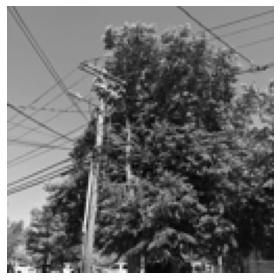

In [9]:
ro = renderOriginal(18, False, True)

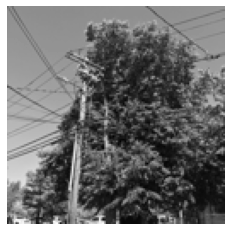

In [10]:
plt.axis('off')
plt.imshow(np.squeeze(validation_images[18]), cmap='gist_gray')

In [158]:
def renderGradCam(index, save=False, grid=False, c_map='gist_gray'):
    '''Visualizing gradient-weighted class activation maps as an overlay (heatmap) to the original image.'''
    gradcam_dir = '../../figures/plottingGradCam/'
    gcam = grad_cam([index])
    class_labels = getClassLabels("PrPo_Im")
    
    if grid==False:
        plt.figure(figsize=(5, 5))
        plt.suptitle('Grad-CAM Index '+str(index)[1:-1]+'\n')
        plt.title('Observed class: '+class_labels[np.argmax(validation_labels[index])], y=-0.08)
        plt.text(-0.7,-0.05, "Probability of prediction: "+ str("{:.0%}".format(float(str(gcam[2])[2:-2])))+'\n', size=12)
        plt.text(-0.7,-0.35, 'Predicted class: '+ str(gcam[3])[2:-2], size=12)
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map) # remove axes of length one from gradcam_images
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5) # overlay
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
    else:
        plt.axis('off')
        plt.tight_layout()
        heatmap = np.uint8(cm.jet(gcam[0])[..., :3] * 255)
        plt.imshow(np.squeeze(gcam[1]), cmap=c_map)
        plt.imshow(heatmap, cmap='gist_gray', alpha=0.5)
    
    if save:
        if not os.path.exists(gradcam_dir):
            os.makedirs(gradcam_dir)
        plt.savefig(gradcam_dir+"gradcam-"+str(index)[1:-1]+".png")
#     plt.show()
    return (heatmap)

Observed image class:  Probable/Possible
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[-4.8984175  2.22506  ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.22506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Probable/Possible']
[array([8.053103e-04, 9.991947e-01], dtype=float32)]
Shape of heatmap matrix: (336, 336)


array([[[  8, 240, 237],
        [ 12, 244, 234],
        [ 18, 252, 228],
        ...,
        [  0,  56, 255],
        [  0,  44, 255],
        [  0,  40, 255]],

       [[ 15, 248, 231],
        [ 15, 248, 231],
        [ 21, 255, 225],
        ...,
        [  0,  60, 255],
        [  0,  48, 255],
        [  0,  44, 255]],

       [[ 24, 255, 221],
        [ 28, 255, 218],
        [ 34, 255, 212],
        ...,
        [  0,  76, 255],
        [  0,  64, 255],
        [  0,  60, 255]],

       ...,

       [[ 70, 255, 176],
        [ 70, 255, 176],
        [ 70, 255, 176],
        ...,
        [  0,  32, 255],
        [  0,  24, 255],
        [  0,  20, 255]],

       [[ 41, 255, 205],
        [ 41, 255, 205],
        [ 44, 255, 202],
        ...,
        [  0,  32, 255],
        [  0,  24, 255],
        [  0,  20, 255]],

       [[ 31, 255, 215],
        [ 31, 255, 215],
        [ 34, 255, 212],
        ...,
        [  0,  36, 255],
        [  0,  24, 255],
        [  0,  24, 255]]

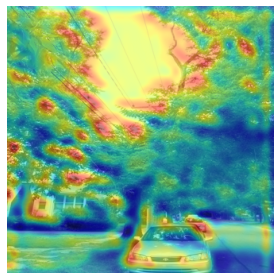

In [159]:
renderGradCam(18, False, True)

In [160]:
def renderGBP(index, normalize=False, save=False, grid=False, c_map='gist_gray'):
    '''Visualizing Guided Backpropagation with an option to use normalized gradients.'''
    gbp = guided_backprop([index], 'conv2d_4')
    gbp_dir = '../../figures/plottingBackProp/'
    save_name = ''
    
    print(np.squeeze(gbp).shape)
    if grid==False:
        standardizePlot(index, gbp_dir, 'Guided Backpropagation')    

        if normalize:
            save_name = gbp_dir+"guided_backprop-"+str(index)+'-normalized-'+c_map+".png"
            normalize_gbp = deprocess_image(np.array(np.squeeze(gbp)))
            plt.imshow(normalize_gbp, cmap = c_map)
        else:
            save_name = gbp_dir+"guided_backprop-"+str(index)+'-'+c_map+".png"
            plt.imshow(np.squeeze(gbp), cmap=c_map)
    else:
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(np.squeeze(gbp), cmap=c_map)
    
    if save:
        plt.savefig(save_name)
    return (gbp)

(336, 336, 3)


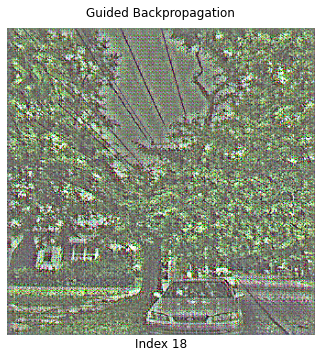

In [161]:
gbp1 = renderGBP(18, True, False, False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


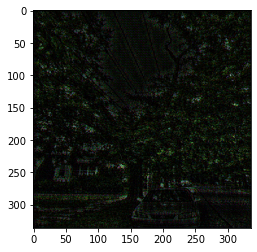

In [95]:
plt.imshow(np.squeeze(gbp1))

In [162]:
def renderGGCAM(index, normalize=False, save=False, grid = False, c_map='gist_gray'):
    '''Visualizing Guided Grad-CAM output with an option to use normalized guided backpropagation gradients.'''
    ggcam_dir = '../../figures/plottingGuided-GradCam/'
    plot_name = ''
    ggcam = guided_gradcam(index, False, 1)
    
    if grid==False:
        if normalize:
            plot_name = "guided-gradcam-"+str(index)+'-'+c_map+'-normalized.png'
            print('Using normalized GBP gradients...')
        else:
            plot_name = "guided-gradcam-"+str(index)+'-'+c_map+".png"
            ggcam = guided_gradcam(index)

        standardizePlot(index, ggcam_dir, 'Guided Grad-CAM')
        plt.imshow(ggcam, cmap=c_map)   
    else:
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(ggcam, cmap=c_map)
    
    if save:
        plt.savefig(ggcam_dir+plot_name)
        print('Saving '+plot_name+' in '+ggcam_dir)
        
    return(ggcam)

Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.9688989>]
Probability of prediction:  ['0.9']
Predicted class:  ['Improbable']
[array([0.90280306, 0.09719698], dtype=float32)]
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336)
Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 0.9688989 -1.259866 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.9688989>]
Probability of prediction:  ['0.9']
Predicted class:  ['Improbable']
[array([0.90280306, 0.09719698], dtype=float32)]
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336)


array([[ 0.00140403,  0.00152326,  0.00257228, ...,  0.00093637,
         0.0005738 , -0.00073742],
       [ 0.00520595, -0.00097317,  0.00408242, ...,  0.00371706,
         0.00336628, -0.00273694],
       [ 0.00215382, -0.00350272, -0.00050787, ...,  0.00077893,
         0.00075663, -0.00062519],
       ...,
       [-0.00086436,  0.00299128, -0.00121402, ..., -0.02552458,
        -0.01503163, -0.00930636],
       [ 0.00351439,  0.01983516, -0.00621635, ..., -0.00131912,
        -0.00596565, -0.00215349],
       [ 0.00176546,  0.00394264, -0.00388031, ...,  0.00273837,
        -0.00133141,  0.00558047]], dtype=float32)

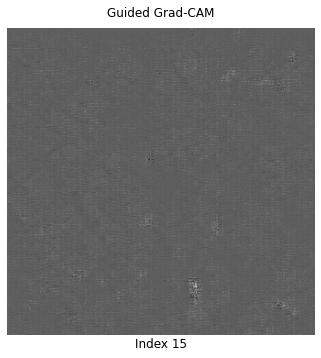

In [163]:
renderGGCAM(15, False, False, False)

Observed image class:  Probable/Possible
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[-4.8984175  2.22506  ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.22506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Probable/Possible']
[array([8.053103e-04, 9.991947e-01], dtype=float32)]
Shape of heatmap matrix: (336, 336)


array([[[  8, 240, 237],
        [ 12, 244, 234],
        [ 18, 252, 228],
        ...,
        [  0,  56, 255],
        [  0,  44, 255],
        [  0,  40, 255]],

       [[ 15, 248, 231],
        [ 15, 248, 231],
        [ 21, 255, 225],
        ...,
        [  0,  60, 255],
        [  0,  48, 255],
        [  0,  44, 255]],

       [[ 24, 255, 221],
        [ 28, 255, 218],
        [ 34, 255, 212],
        ...,
        [  0,  76, 255],
        [  0,  64, 255],
        [  0,  60, 255]],

       ...,

       [[ 70, 255, 176],
        [ 70, 255, 176],
        [ 70, 255, 176],
        ...,
        [  0,  32, 255],
        [  0,  24, 255],
        [  0,  20, 255]],

       [[ 41, 255, 205],
        [ 41, 255, 205],
        [ 44, 255, 202],
        ...,
        [  0,  32, 255],
        [  0,  24, 255],
        [  0,  20, 255]],

       [[ 31, 255, 215],
        [ 31, 255, 215],
        [ 34, 255, 212],
        ...,
        [  0,  36, 255],
        [  0,  24, 255],
        [  0,  24, 255]]

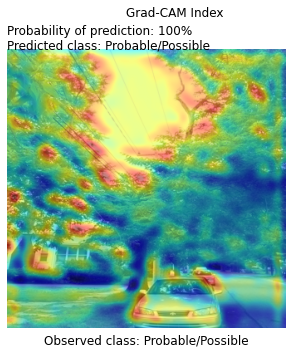

In [164]:
renderGradCam(18)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(336, 336, 3)


<tf.Tensor: shape=(336, 336, 3), dtype=float32, numpy=
array([[[ 0.02965423,  0.00355466,  0.00086316],
        [ 0.02162674,  0.00323819, -0.0216712 ],
        [ 0.00855987, -0.00517111,  0.03512616],
        ...,
        [ 0.00209504,  0.0345336 , -0.01438267],
        [ 0.02976094,  0.03420107,  0.01127638],
        [-0.00917591,  0.01762694, -0.01517917]],

       [[ 0.0020011 ,  0.03729653, -0.0123872 ],
        [-0.00093906,  0.01339723, -0.00778115],
        [ 0.01573088,  0.03845045,  0.03150411],
        ...,
        [ 0.02811361,  0.04005797, -0.00067381],
        [ 0.00156687,  0.02202789,  0.00889727],
        [ 0.01511502,  0.02403399,  0.0054106 ]],

       [[-0.0043294 , -0.00588437,  0.02354454],
        [ 0.0505743 ,  0.00746322, -0.01180627],
        [ 0.05219021,  0.02724903,  0.08230056],
        ...,
        [ 0.02184149,  0.01067896,  0.02902445],
        [ 0.05439676,  0.02573859,  0.00323261],
        [ 0.04798522, -0.00660673, -0.01959837]],

       ...,

     

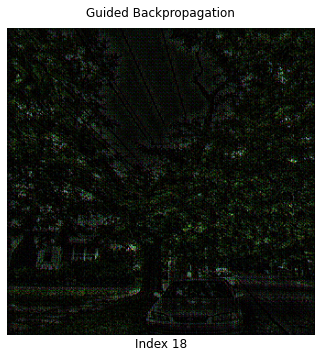

In [165]:
renderGBP(18)

(336, 336, 3)


<tf.Tensor: shape=(336, 336, 3), dtype=float32, numpy=
array([[[ 0.02965423,  0.00355466,  0.00086316],
        [ 0.02162674,  0.00323819, -0.0216712 ],
        [ 0.00855987, -0.00517111,  0.03512616],
        ...,
        [ 0.00209504,  0.0345336 , -0.01438267],
        [ 0.02976094,  0.03420107,  0.01127638],
        [-0.00917591,  0.01762694, -0.01517917]],

       [[ 0.0020011 ,  0.03729653, -0.0123872 ],
        [-0.00093906,  0.01339723, -0.00778115],
        [ 0.01573088,  0.03845045,  0.03150411],
        ...,
        [ 0.02811361,  0.04005797, -0.00067381],
        [ 0.00156687,  0.02202789,  0.00889727],
        [ 0.01511502,  0.02403399,  0.0054106 ]],

       [[-0.0043294 , -0.00588437,  0.02354454],
        [ 0.0505743 ,  0.00746322, -0.01180627],
        [ 0.05219021,  0.02724903,  0.08230056],
        ...,
        [ 0.02184149,  0.01067896,  0.02902445],
        [ 0.05439676,  0.02573859,  0.00323261],
        [ 0.04798522, -0.00660673, -0.01959837]],

       ...,

     

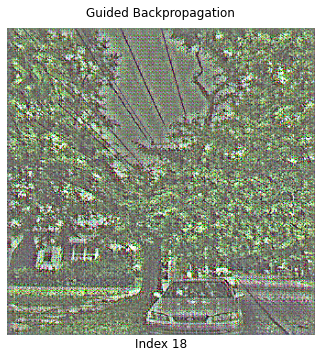

In [166]:
renderGBP(18, True)

Observed image class:  Probable/Possible
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[-4.8984175  2.22506  ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.22506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Probable/Possible']
[array([8.053103e-04, 9.991947e-01], dtype=float32)]
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336)
Observed image class:  Probable/Possible
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[-4.8984175  2.22506  ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.22506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Probable/Possible']
[array([8.053103e-04, 9.991947e-01], dtype=float32)]
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336)


array([[ 0.01075589,  0.00129897,  0.00032153, ...,  0.00720005,
         0.00059483, -0.00505386],
       [ 0.00721927,  0.00746649,  0.01011122, ...,  0.00139329,
        -0.00156217, -0.0013133 ],
       [ 0.0004093 ,  0.01659445,  0.00057115, ..., -0.0018461 ,
         0.00332895, -0.00279648],
       ...,
       [ 0.00158663,  0.01606327,  0.00160806, ..., -0.00061564,
         0.00413901, -0.00207035],
       [ 0.03350031,  0.03132359,  0.0171496 , ..., -0.00628649,
        -0.00086894, -0.00961074],
       [ 0.03978176,  0.0864469 ,  0.04373724, ..., -0.00175952,
        -0.00273398, -0.00023285]], dtype=float32)

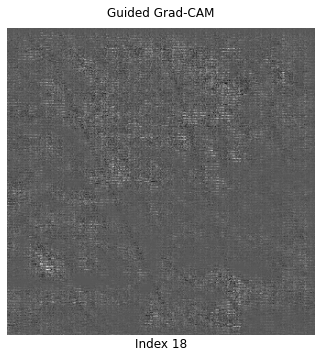

In [167]:
renderGGCAM(18)

Observed image class:  Probable/Possible
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[-4.8984175  2.22506  ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.22506>]
Probability of prediction:  ['1.0']
Predicted class:  ['Probable/Possible']
[array([8.053103e-04, 9.991947e-01], dtype=float32)]
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336)


array([[ 0.01075589,  0.00129897,  0.00032153, ...,  0.00720005,
         0.00059483, -0.00505386],
       [ 0.00721927,  0.00746649,  0.01011122, ...,  0.00139329,
        -0.00156217, -0.0013133 ],
       [ 0.0004093 ,  0.01659445,  0.00057115, ..., -0.0018461 ,
         0.00332895, -0.00279648],
       ...,
       [ 0.00158663,  0.01606327,  0.00160806, ..., -0.00061564,
         0.00413901, -0.00207035],
       [ 0.03350031,  0.03132359,  0.0171496 , ..., -0.00628649,
        -0.00086894, -0.00961074],
       [ 0.03978176,  0.0864469 ,  0.04373724, ..., -0.00175952,
        -0.00273398, -0.00023285]], dtype=float32)

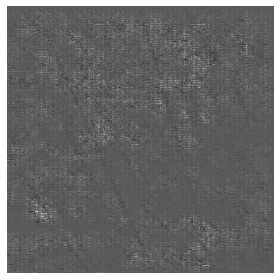

In [168]:
renderGGCAM(18, True, False, 'jet')

In [169]:
def plotVisualizations(index, save=False):
    subplot_args = { 'nrows': 1, 'ncols': 4, 'figsize': (15, 15), 
                    'subplot_kw': {'xticks': [], 'yticks': []} }
    grid_dir = '../../figures/'
    plot_name = 'plot_grid_'+str(index)
    f, axs = plt.subplots(**subplot_args)
    f.set_facecolor("white")
    axis_labels = ['Processed Input', 'GradCAM', 'Guided Backprop', 'Guided GradCAM']
    orig_image = validation_images[index]
    gcam_heatmap = renderGradCam(index, False, True)    
    gbp = renderGBP(index, False, False, True)
    ggcam = renderGGCAM(index, False, False, True)
    f.suptitle('Observed: ' + class_labels[np.argmax(validation_labels[index])]+ '. Predicted: ' + str(grad_cam([index])[3])[2:-2]+'. Probability: '+str("{:.0%}".format(float(str(grad_cam([index])[2])[2:-2])))+'.', y=0.595, fontsize=24, va='bottom') 
    axs[0].imshow(np.squeeze(orig_image), cmap='gist_gray')
    axs[1].imshow(np.squeeze(orig_image), cmap='gist_gray')
    axs[1].imshow(gcam_heatmap, cmap = 'jet', alpha=0.5)
    axs[2].imshow(np.squeeze(gbp), cmap='jet')
    axs[3].imshow(ggcam)
    for axis in f.axes:
        axis.set_axis_on()
        axis.set_xticks([])
        axis.set_yticks([])
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.spines["left"].set_visible(False)
        axis.spines["bottom"].set_visible(False)        
    for i, axis in enumerate(f.axes):
        axis.set_xlabel(axis_labels[i], fontsize=18)
    f.tight_layout(rect=[0, 0, 1, 0.95])
    if save:
        f.savefig(grid_dir+plot_name, bbox_inches='tight')
        print('Saving '+plot_name+' in '+grid_dir)
    return 

Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 1.244857  -1.3165252]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=1.244857>]
Probability of prediction:  ['0.93']
Predicted class:  ['Improbable']
[array([0.92833453, 0.07166554], dtype=float32)]
Shape of heatmap matrix: (336, 336)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(336, 336, 3)
Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 1.244857  -1.3165252]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=1.244857>]
Probability of prediction:  ['0.93']
Predicted class:  ['Improbable']
[array([0.92833453, 0.07166554], dtype=float32)]
Shape of heatmap matrix: (336, 336)
Shape of GGCAM:  (336, 336)
Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 1.244857  -1.3165252]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=1.244857>]
Probability of prediction:  ['0.93']
Predicted class:  ['Improbable']
[array([0.92833453, 0.07166554], dtype=float32)]
Shape of heatmap matrix: (336, 336)
Observed image class:  Improbable
Class labels:  ['Improbable', 'Probable/Possible']
Loss output:  tf.Tensor([[ 1.244857  -1.3165252]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


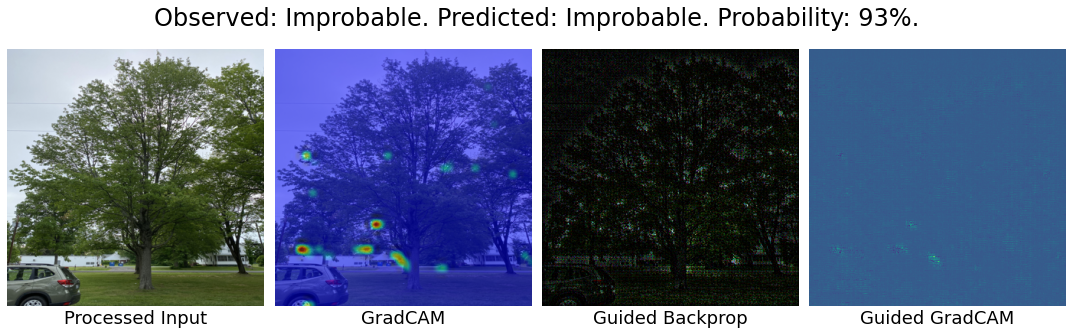

In [171]:
plotVisualizations(108, False)